<a href="https://colab.research.google.com/github/morreh89/clinical-test-for-hypothyroidism/blob/main/Nairobi_Clinical_test_for_hypothyroidism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HYPOTHYROIDISM PREDICTION - NAIROBI HOSPITAL

## Research Question
*Build a model that determines whether or not the patient's symptoms indicate whether a patient has hypothyroid or not*

## Metrics of Success
*The accuracy score and f1 score will be used to measure and evaluate the predictive power the of models*

## Importing libraries

In [ ]:
# Importing python libraries
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style = 'darkgrid')
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz 
from IPython.display import Image  
import pydotplus
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import warnings
warnings.filterwarnings(action = 'ignore')

## Loading the data to a pandas dataframe

In [ ]:
# Creating a function to read a shared csv file via google drive
#
def read_csv(url):
  url = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
  csv_raw = requests.get(url).text
  csv = StringIO(csv_raw)
  return csv

# Reading the csv file to a dataframe using the pandas library
#
df = pd.read_csv(read_csv('https://drive.google.com/file/d/1GWCN3d14O89gfyT0QQLs7FbeaX1iXT-U/view?usp=sharing'))

# Previewing the first five rows of the dataframe
#
df.head()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72,M,f,f,f,f,f,f,f,f,f,f,f,y,30,y,0.60,y,15,y,1.48,y,10,n,?
1,hypothyroid,15,F,t,f,f,f,f,f,f,f,f,f,f,y,145,y,1.70,y,19,y,1.13,y,17,n,?
2,hypothyroid,24,M,f,f,f,f,f,f,f,f,f,f,f,y,0,y,0.20,y,4,y,1,y,0,n,?
3,hypothyroid,24,F,f,f,f,f,f,f,f,f,f,f,f,y,430,y,0.40,y,6,y,1.04,y,6,n,?
4,hypothyroid,77,M,f,f,f,f,f,f,f,f,f,f,f,y,7.30,y,1.20,y,57,y,1.28,y,44,n,?


In [ ]:
# Previweing some information about the dataframe
#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   status                     3163 non-null   object
 1   age                        3163 non-null   object
 2   sex                        3163 non-null   object
 3   on_thyroxine               3163 non-null   object
 4   query_on_thyroxine         3163 non-null   object
 5   on_antithyroid_medication  3163 non-null   object
 6   thyroid_surgery            3163 non-null   object
 7   query_hypothyroid          3163 non-null   object
 8   query_hyperthyroid         3163 non-null   object
 9   pregnant                   3163 non-null   object
 10  sick                       3163 non-null   object
 11  tumor                      3163 non-null   object
 12  lithium                    3163 non-null   object
 13  goitre                     3163 non-null   object
 14  TSH_meas

In [ ]:
# Checking for some statistical summariess of the dataframe
# Transposing the summaries for a better view
#
df.describe().T

,count,unique,top,freq
status,3163,2,negative,3012
age,3163,93,?,446
sex,3163,3,F,2182
on_thyroxine,3163,2,f,2702
query_on_thyroxine,3163,2,f,3108
on_antithyroid_medication,3163,2,f,3121
thyroid_surgery,3163,2,f,3059
query_hypothyroid,3163,2,f,2922
query_hyperthyroid,3163,2,f,2920
pregnant,3163,2,f,3100


*The gender has three unique values, further investigation is needed. Some columns have a "?", thus require further probing*

## Data cleaning

In [ ]:
# Checking for the shape and size of the dataframe
#
print(f'The shape is {df.shape} and the size is {df.size}')

The shape is (3163, 26) and the size is 82238


#### Checking for and removing duplicates

In [ ]:
# Checking for duplicates
#
df.duplicated().any()

True

In [ ]:
# Previewing the first five rows of the duplicated data
#
df[df.duplicated()].head()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
53,hypothyroid,69,F,f,f,f,f,f,f,f,f,f,f,f,y,21,y,0.80,y,53,y,0.86,y,61,n,?
66,hypothyroid,62,M,f,f,f,f,f,f,f,f,f,f,f,y,100,y,0.40,y,10,y,1,y,10,n,?
124,hypothyroid,77,F,f,f,f,f,f,f,f,f,f,f,f,y,23,y,0.50,y,33,y,0.67,y,49,n,?
128,hypothyroid,79,F,f,f,f,f,f,f,f,f,f,f,f,y,29,y,1.60,y,47,y,0.97,y,48,n,?
131,hypothyroid,50,F,t,f,f,f,f,f,f,f,f,f,f,y,34,n,?,y,55,y,0.93,y,60,n,?


In [ ]:
# Checking for how many data points have been duplicated 
#
print(len(df[df.duplicated()]))

77


In [ ]:
# Removing duplicates
# Keeping every first data point of the duplicated datapoints
#
df.drop_duplicates(keep='first', inplace = True)

# Checking to confirm whether duplicates have been dropped
#
df.duplicated().any()

False

#### Cleaning column names

In [ ]:
# Previewing the columns of the dataframe
#
print(df.columns)

Index(['status', 'age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'thyroid_surgery', 'query_hypothyroid',
       'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre',
       'TSH_measured', 'TSH', 'T3_measured', 'T3', 'TT4_measured', 'TT4',
       'T4U_measured', 'T4U', 'FTI_measured', 'FTI', 'TBG_measured', 'TBG'],
      dtype='object')


In [ ]:
# For consistency and easy reference the columns should be uniform
# Changing all column names to lower case
#
df.columns = df.columns.str.lower()

# Previewing the columns to confirm whether the changes have taken effect
#
df.columns

Index(['status', 'age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'thyroid_surgery', 'query_hypothyroid',
       'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre',
       'tsh_measured', 'tsh', 't3_measured', 't3', 'tt4_measured', 'tt4',
       't4u_measured', 't4u', 'fti_measured', 'fti', 'tbg_measured', 'tbg'],
      dtype='object')

#### Checking for consistency, uniformity and accuracy

In [ ]:
# Checking for the number of unique values in each column
# This is to check for consistency, uniformity and accuracy
# A for loop has been used to print unique values for each column
#
for column in df.columns:
  print(column)
  print(df[column].nunique())
  print(df[column].unique())
  print('\n')

status
2
['hypothyroid' 'negative']


age
93
['72' '15' '24' '77' '85' '64' '20' '42' '69' '75' '53' '59' '68' '50'
 '78' '65' '28' '43' '40' '84' '?' '83' '63' '73' '36' '27' '48' '71' '60'
 '34' '79' '62' '74' '32' '41' '70' '29' '5' '58' '35' '51' '22' '16' '44'
 '39' '47' '18' '17' '88' '56' '30' '45' '66' '52' '54' '80' '33' '38'
 '92' '67' '46' '13' '89' '61' '49' '26' '57' '31' '90' '81' '25' '37'
 '76' '87' '23' '55' '86' '98' '21' '97' '1' '6' '14' '82' '11' '19' '9'
 '12' '10' '8' '7' '4' '93']


sex
3
['M' 'F' '?']


on_thyroxine
2
['f' 't']


query_on_thyroxine
2
['f' 't']


on_antithyroid_medication
2
['f' 't']


thyroid_surgery
2
['f' 't']


query_hypothyroid
2
['f' 't']


query_hyperthyroid
2
['f' 't']


pregnant
2
['f' 't']


sick
2
['f' 't']


tumor
2
['f' 't']


lithium
2
['f' 't']


goitre
2
['f' 't']


tsh_measured
2
['y' 'n']


tsh
240
['30' '145' '0' '430' '7.30' '138' '7.70' '21' '92' '48' '36' '15' '15.30'
 '25' '61' '28' '170' '54' '216' '56' '71' '46' '70' '34

*From the above analysis, it can be observed that the sex column and the tbg columns have datapoints with a '?'. Clearly these are missing values. They will be replaced with a NaN value*

---

*Some columns have a True or False value, therefore their datatypes will be changed appriopriately*

#### Checking for and dealing with missing values

In [ ]:
# Replacing the '?' character in the dataframe with NAN
#
df.replace('?', np.nan, inplace=True)

In [ ]:
# Checking for missing values as a percentage
# Sorting the missing values in a descending order
#
(df.isna().mean().round(4) * 100).sort_values(ascending = False)

tbg                          91.87
t3                           22.03
tsh                          14.74
age                          14.19
tt4                           7.78
t4u                           7.74
fti                           7.71
sex                           2.37
pregnant                      0.00
on_thyroxine                  0.00
query_on_thyroxine            0.00
on_antithyroid_medication     0.00
thyroid_surgery               0.00
query_hypothyroid             0.00
query_hyperthyroid            0.00
lithium                       0.00
sick                          0.00
tumor                         0.00
tbg_measured                  0.00
goitre                        0.00
tsh_measured                  0.00
t3_measured                   0.00
tt4_measured                  0.00
t4u_measured                  0.00
fti_measured                  0.00
status                        0.00
dtype: float64

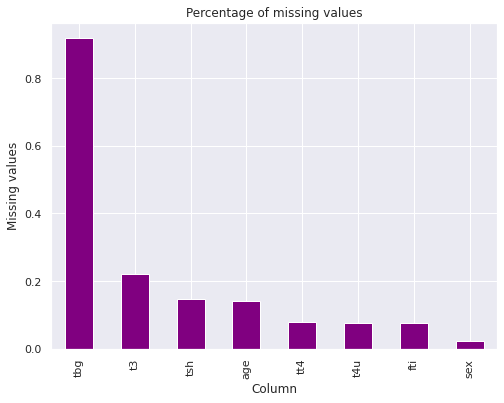

In [ ]:
# Visualising missing values
#
df.isna().mean().round(4).sort_values(ascending = False)[:8].plot(kind = 'bar', figsize = (8, 6), color = 'purple')
plt.title('Percentage of missing values')
plt.ylabel('Missing values')
plt.xlabel('Column')
plt.show()

*The tbg column has more than 91% missing values, therefore it will be dropped, the missing values in the sex column will be filled with the mode and all other missing values in numerical columns will be filled with their mean*

In [ ]:
# Checking the datatype of each column
# Before filling missing values, the column dtypes should first be changed to their appriopriate datatype
#
df.dtypes

status                       object
age                          object
sex                          object
on_thyroxine                 object
query_on_thyroxine           object
on_antithyroid_medication    object
thyroid_surgery              object
query_hypothyroid            object
query_hyperthyroid           object
pregnant                     object
sick                         object
tumor                        object
lithium                      object
goitre                       object
tsh_measured                 object
tsh                          object
t3_measured                  object
t3                           object
tt4_measured                 object
tt4                          object
t4u_measured                 object
t4u                          object
fti_measured                 object
fti                          object
tbg_measured                 object
tbg                          object
dtype: object

In [ ]:
# Changing column datatypes to their appriopriate datatypes
# Lists of numerical, categorical and bool columns have been created for efficiency
# Numerical columns list
#
num_cols = ['age', 'tsh', 't3', 'tt4', 't4u', 'fti']

# Categorical columns list
cat_cols = ['status', 'sex','tsh_measured', 't3_measured', 'tt4_measured',\
            't4u_measured', 'fti_measured', 'tbg_measured']

# Boolean columns list
bool_cols = ['on_thyroxine', 'query_on_thyroxine','on_antithyroid_medication', 'thyroid_surgery', 'query_hypothyroid',\
            'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre']

# Replacing bool columns with True or False value
#
for column in bool_cols:
  df[column] = df[column].replace('f', False)
  df[column] = df[column].replace('t', True)
  
# Using a for loop to change columns to their appriopriate datatypes
#
for column in df.columns:
  if column in num_cols:
    df[column] = df[column].astype('float')
  elif column in cat_cols:
    df[column] = df[column].astype('category')
  elif column in bool_cols:
    df[column] = df[column].astype('bool')
  
# Previewing the column datatypes to check whether the changes have been effected
#
df.dtypes

status                       category
age                           float64
sex                          category
on_thyroxine                     bool
query_on_thyroxine               bool
on_antithyroid_medication        bool
thyroid_surgery                  bool
query_hypothyroid                bool
query_hyperthyroid               bool
pregnant                         bool
sick                             bool
tumor                            bool
lithium                          bool
goitre                           bool
tsh_measured                 category
tsh                           float64
t3_measured                  category
t3                            float64
tt4_measured                 category
tt4                           float64
t4u_measured                 category
t4u                           float64
fti_measured                 category
fti                           float64
tbg_measured                 category
tbg                            object
dtype: objec

In [ ]:
# Filling missing values
# Dropping columns with more than 90% of missing values
# Dropping the tbg and tbg_measured columns
#
df.drop(['tbg', 'tbg_measured'], axis = 1, inplace = True)

# Filling missing values in the sex column with mode
#
df.sex.fillna(df.sex.mode()[0], inplace = True)

# Filling missing values in numerical columns with mean
# A for loop has been used for efficiency
#
for column in num_cols:
  df[column].fillna(df[column].mean(), inplace = True)
  
# Checking whether the missing values have been filled appriopriately
#
df.isnull().sum().any()

False

In [ ]:
# Previewing the head of the cleaned data
#
df.head()

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,tsh_measured,tsh,t3_measured,t3,tt4_measured,tt4,t4u_measured,t4u,fti_measured,fti
0,hypothyroid,72.0,M,False,False,False,False,False,False,False,False,False,False,False,y,30.0,y,0.6,y,15.0,y,1.48,y,10.0
1,hypothyroid,15.0,F,True,False,False,False,False,False,False,False,False,False,False,y,145.0,y,1.7,y,19.0,y,1.13,y,17.0
2,hypothyroid,24.0,M,False,False,False,False,False,False,False,False,False,False,False,y,0.0,y,0.2,y,4.0,y,1.00,y,0.0
3,hypothyroid,24.0,F,False,False,False,False,False,False,False,False,False,False,False,y,430.0,y,0.4,y,6.0,y,1.04,y,6.0
4,hypothyroid,77.0,M,False,False,False,False,False,False,False,False,False,False,False,y,7.3,y,1.2,y,57.0,y,1.28,y,44.0


## Boxplots to show outliers

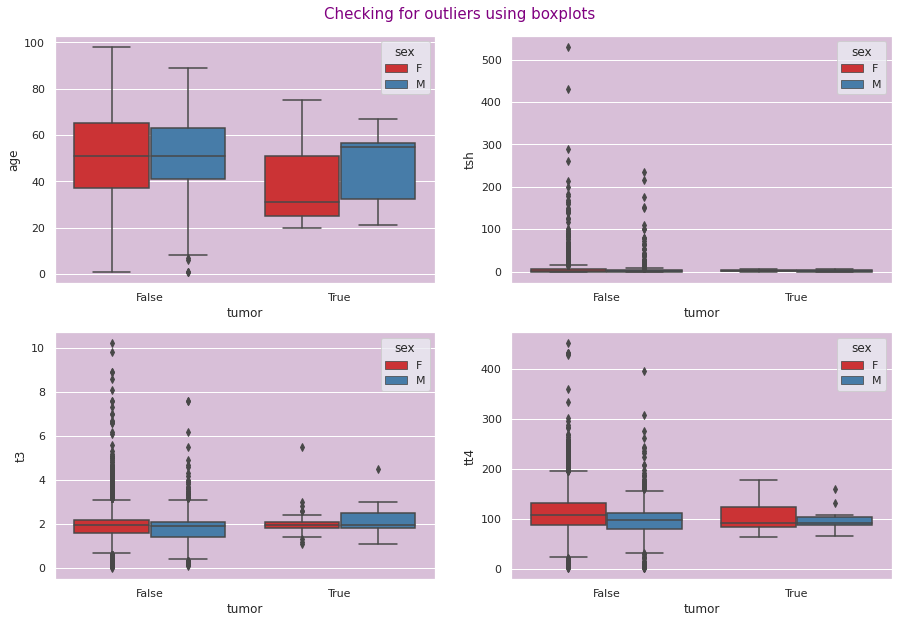

In [ ]:
# Plotting boxplots to check for outliers
#
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
plt.suptitle('Checking for outliers using boxplots', fontsize = 15, y = 0.92, color = 'purple')
for ax, data, column in zip(axes.flatten(), df, num_cols):
  sns.boxplot(df.tumor, df[column], ax = ax, hue = df.sex, palette = 'Set1')
  ax.set_facecolor('thistle') # Setting the background color to thistle

*From the above chart we can make these observations*


*   There is are no outliers in the age column
*   The **tsh** column has the most outliers when compared with t3 and tt4, when tumor diagnosis is negative
*   Across the **t3**, **tt4** and **tsh** columns, outliers are more pronounced when diagnosis for tumor is negative


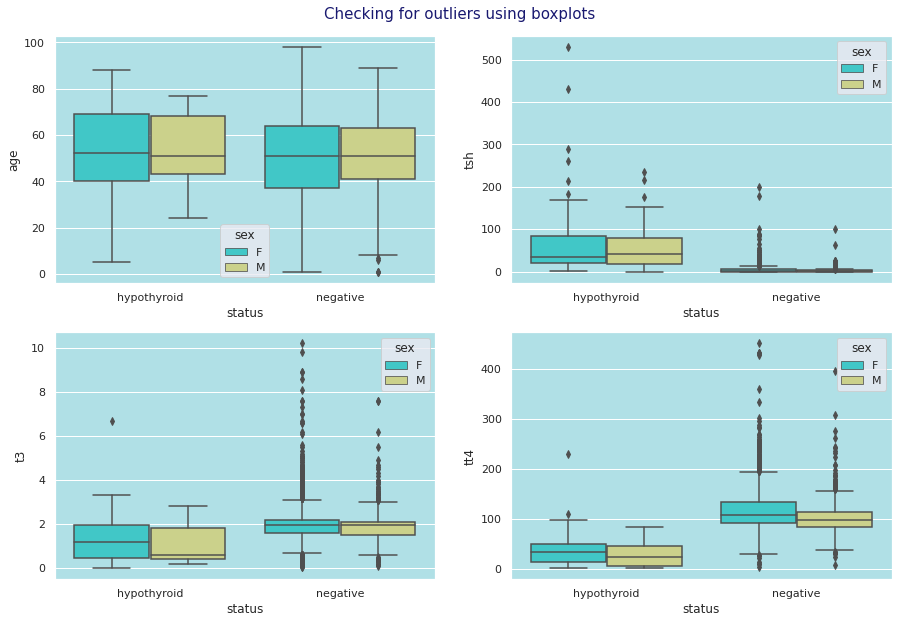

In [ ]:
# Plotting boxplots to check for outliers
#
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
plt.suptitle('Checking for outliers using boxplots', fontsize = 15, y = 0.92, color = 'midnightblue')
for ax, data, column in zip(axes.flatten(), df, num_cols):
  sns.boxplot(df.status, df[column], ax = ax, hue = df.sex, palette = 'rainbow')
  ax.set_facecolor('powderblue') # Setting the background color to powderblue

*From the above chart we can make these observations;*


*   The distribution of age is approximately the same irrespective of whether a person has hypothyroid or not
*   The **tsh** column has the most outliers when compared with t3 and tt4, when hypothyroid diagnosis is positive
*   Across the **t3**, **tt4** and **tsh** columns, outliers are more pronounced when diagnosis for hypothyroid is negative


## Violin plots

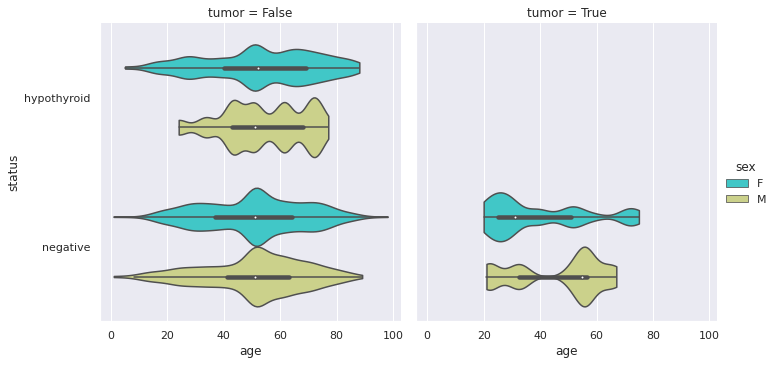

In [ ]:
# Plotting violin plots
  #
sns.catplot(x="age", y="status",hue="sex",col = 'tumor', data=df,orient="h", height=5, aspect=1, palette="rainbow", kind="violin", dodge=True, cut=0, bw=.2)
plt.show()

*From the above chart we can make these observations*


*   All individuals who have a tumor have hypothyroid
*   The ages of most males with hypothyroid lie between approximately 22 and 78

## Bar charts

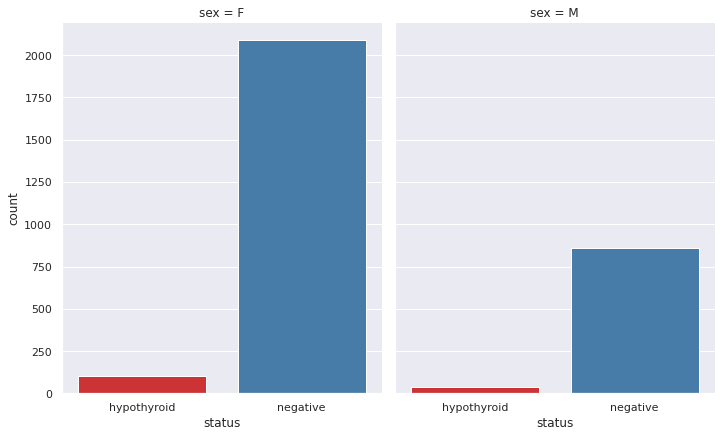

In [ ]:
# Plotting bar charts
#
sns.catplot("status", col="sex", col_wrap=4, data=df, kind="count", height=6, aspect=.8, palette='Set1')
plt.show()

*From the above chart we can make these observations;*


*   The dataset is highly imbalanced, it has more negative cases than hypothyroid cases
*   More females have hypothyroid as compared to men

## Distribution of age per gender - Histograms

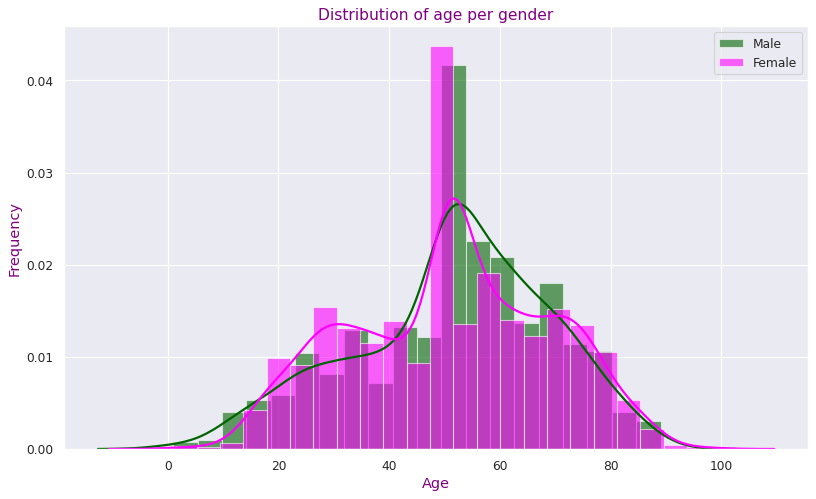

In [ ]:
# Plotting histogram to show distribution of age per gender
# 
male = df.loc[df.sex=='M', 'age']    # Selecting only male datapoints in the age column
female = df.loc[df.sex=='F', 'age']  # Selecting only female datapoints in the age column

# Creating a dictionary containing opacaticy and line width in a dictionary for efficiency
#
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

# Plotting the histograms
#
plt.figure(figsize=(12,7), dpi= 80)
sns.distplot(male, color="darkgreen", label="Male", **kwargs)
sns.distplot(female, color="fuchsia", label="Female", **kwargs)
plt.title('Distribution of age per gender', fontsize = 14, color = 'purple')
plt.xlabel('Age', fontsize = 13, color = 'purple')
plt.ylabel('Frequency', fontsize = 13, color = 'purple')
plt.legend()
plt.show()

*From the above histogram, it can be deduced that both the ages of male and female are skewed to the left. This means that the median and mode is greater than the mean*

## Scatter plot to show relationships of variables

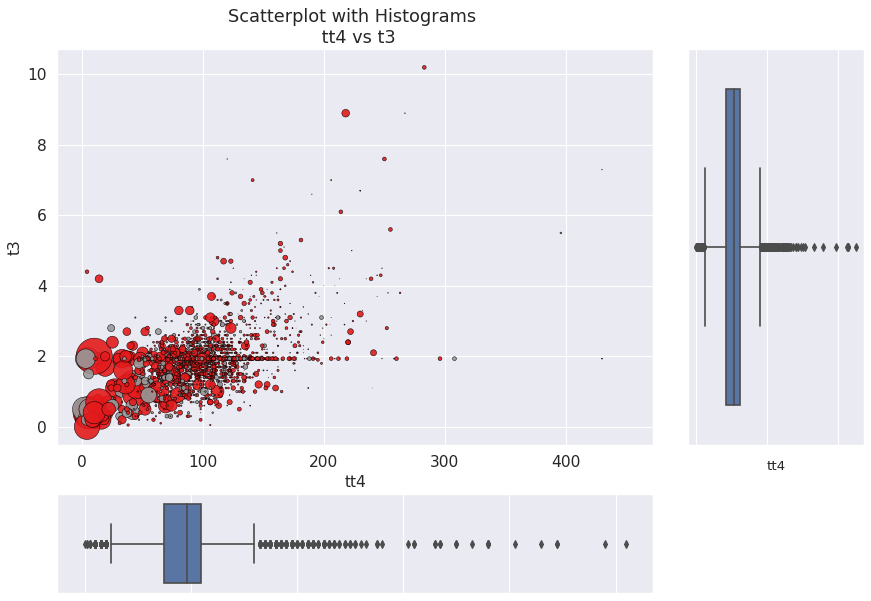

In [ ]:
# Create Fig and gridspec
#
fig = plt.figure(figsize=(13, 9), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
# Define the axes
#
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])
# Scatterplot on main ax
#
ax_main.scatter('tt4', 't3', s=df.tsh*2, c=df.sex.cat.codes, alpha=.9, data=df, cmap="Set1", edgecolors='black', linewidths=.5)
# Add a graph in each part
#
sns.boxplot(df.tt4, ax=ax_right, orient="v")
sns.boxplot(df.t3, ax=ax_bottom, orient="h")
# Remove x axis name for the boxplot by assigning it to nothing
# This is done to increase visibility
#
ax_bottom.set(xlabel='')
ax_right.set(ylabel='')
# Main Title, Xlabel and YLabel
#
ax_main.set(title='Scatterplot with Histograms \n tt4 vs t3', xlabel='tt4', ylabel='t3')
# Using a for loop to set the font size of different components
#
ax_main.title.set_fontsize(16)
for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)    
plt.show()

*From the above chart we can make these observations*


*   There is a strong positive relationship between **tt4** and **t3**
*   **tt4** is skewed to the right which means that the mean is greater than the mode and the median
*   **t3** is also skewed to the right
*   The values of **tsh** are bigger when both **tt4** and **t4** values are low



## Density plots to show distributions
Density plots are used tool visualise the distribution of a continuous variables

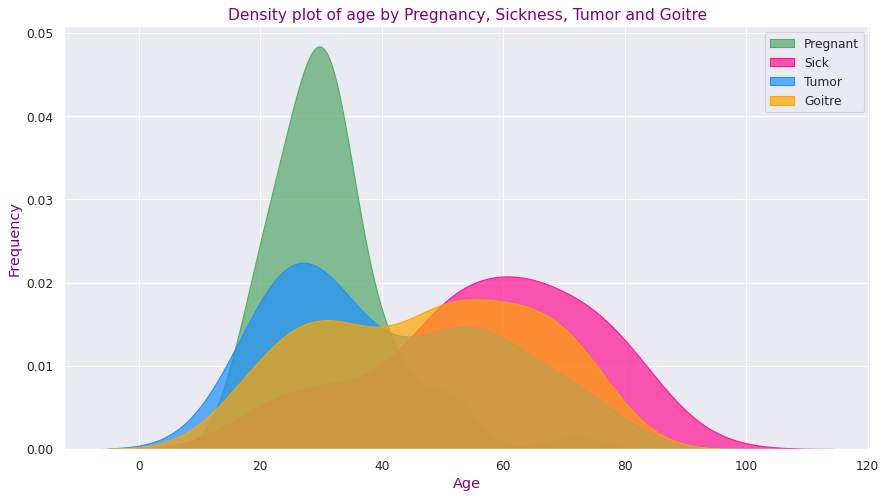

In [ ]:
# Plotting Kernel Density Estimate plots for pregnant, sick, tumor and goitre persons
# Setting the figuresize of the graph to 13 in length and 7 in height
#
plt.figure(figsize=(13,7), dpi= 80)
sns.kdeplot(df.loc[df['pregnant'] == True, "age"], shade=True, color="g", label="Pregnant", alpha=.7)
sns.kdeplot(df.loc[df['sick'] == True, "age"], shade=True, color="deeppink", label="Sick", alpha=.7)
sns.kdeplot(df.loc[df['tumor'] == True, "age"], shade=True, color="dodgerblue", label="Tumor", alpha=.7)
sns.kdeplot(df.loc[df['goitre'] == True, "age"], shade=True, color="orange", label="Goitre", alpha=.7)
plt.title('Density plot of age by Pregnancy, Sickness, Tumor and Goitre', fontsize=14, color = 'purple')
plt.xlabel('Age', fontsize = 13, color = 'purple')
plt.ylabel('Frequency', color = 'purple', fontsize = 13)
plt.legend()
plt.show()

*From the above chart we can make these observations*


*   Majority of women who are pregnant lie between the ages of approximately 18 and 40
*   The distribution of sick people is skewed to the left
*   Distribution of people with goitre is normally distributed

## Correlogram to show correlations between variables

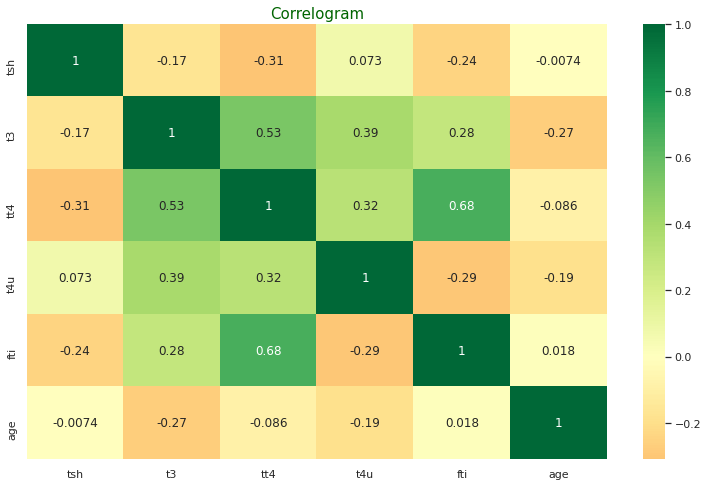

In [ ]:
# Plotting a heatmap to show correlations between variables
#
corr = df[['tsh', 't3', 'tt4', 't4u', 'fti', 'age']].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

*From the above chart we can make these observations*


*   There is a strong positive relationship between **fti** and **tt4** - 0.68
*   **tt4** and **t3** have a postive relationship with a correlation coefficient of 0.53

## Pairplots

<Figure size 480x320 with 0 Axes>

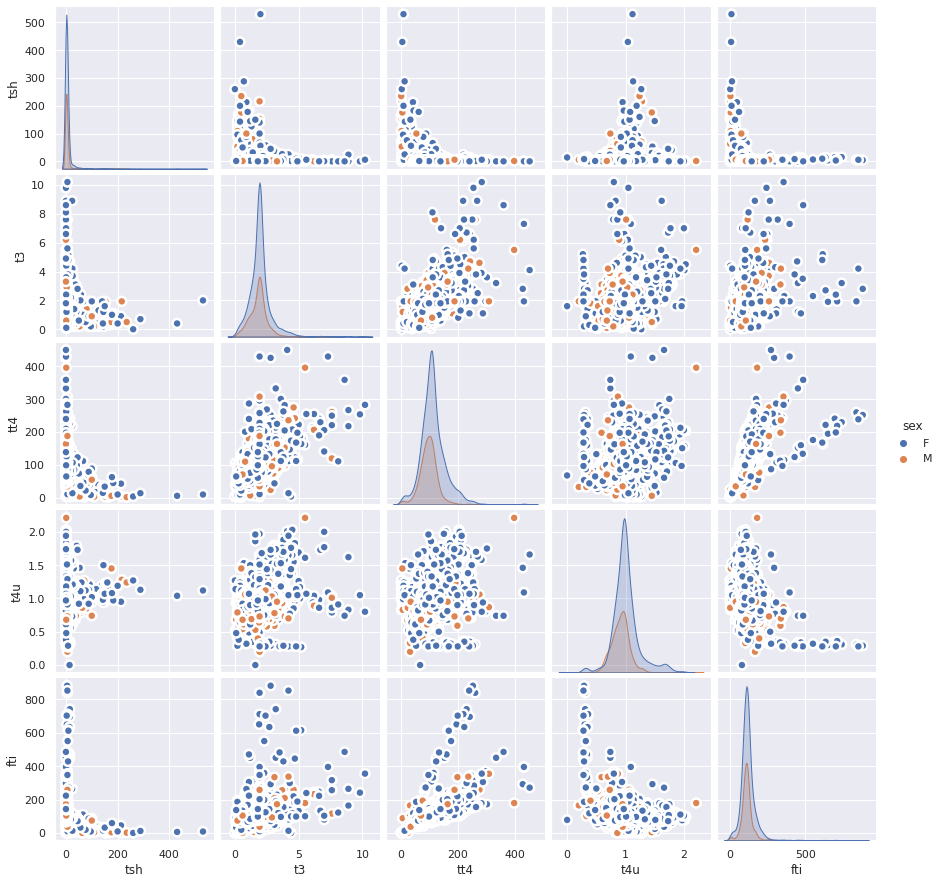

In [ ]:
plt.figure(dpi= 80)
sns.pairplot(df[['tsh', 't3', 'tt4', 't4u', 'fti', 'sex']], kind="scatter", hue="sex", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

# Modelling

## RandomForestClassifier

In [ ]:
# Selecting the independent variables and the target variable
#
X = df.drop('status', axis = 1)
y = np.where(df.status == 'hypothyroid', 1, 0)

# Encoding categorical variables
#
X = pd.get_dummies(X)

# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
#
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)

# Making predictions
#
y_pred = rf.predict(X_test)

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)} and the f1 score is {f1_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

The accuracy score is: 0.990280777537797 and the f1 score is 0.8799999999999999


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       887
           1       0.92      0.85      0.88        39

    accuracy                           0.99       926
   macro avg       0.95      0.92      0.94       926
weighted avg       0.99      0.99      0.99       926



array([[884,   3],
       [  6,  33]])

### Feature Importance

In [ ]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X.columns, 'importance': np.round(rf.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df

,importance
feature,
fti,0.3039
tsh,0.2379
tt4,0.2246
t3,0.0786
t4u,0.0479
age,0.0427
query_hypothyroid,0.0100
on_antithyroid_medication,0.0097
tsh_measured_n,0.0060


### Visualising the most important features

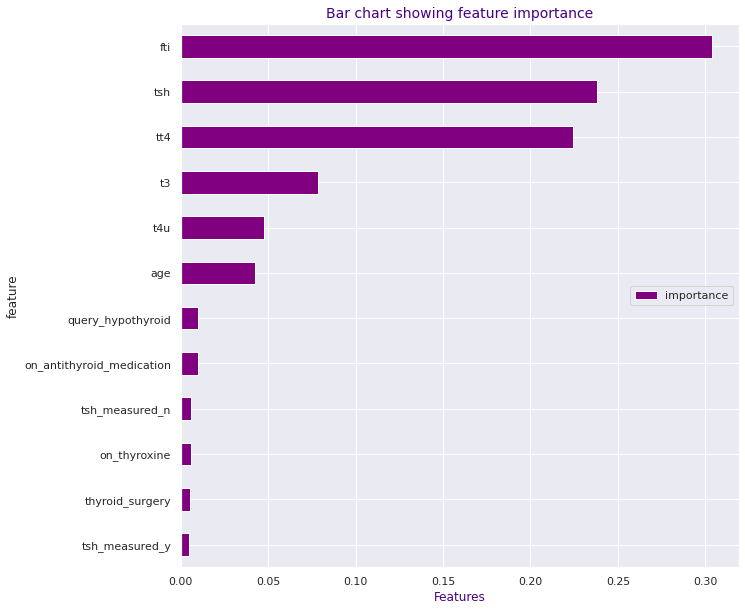

In [ ]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

*From the above feature importance barchart, it can be observed that:*


*   The most important feature in predicting whether a paerson has hypothyroid or not is **fti**
*   The following features are not important in predicting the target;
                      * tt4_measured_y   * tt4_measured_n   * tumor               * query_on_thyroxine
                      * t4u_measured_n   * t4u_measured_y   * t3_measured_n       * t3_measured_y
                      * pregnant         * fti_measured_n   * query_hyperthyroid  * on_antithyroid_medication
                      * lithium          * fti_measured_y   * goitre              


### Remodelling with the most important features only

In [ ]:
# Selecting only important features and the y variable
#
X = X[['age', 'on_thyroxine', 'sex_F', 'sex_M', 'tsh_measured_y',
        'thyroid_surgery', 'sick', 'tsh', 't3', 'tt4', 't4u', 'fti', 'tsh_measured_n']]

y = np.where(df.status == 'hypothyroid', 1, 0)

# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
#
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)

# Making predictions
#
y_pred = rf.predict(X_test)

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)} and the f1 score is {f1_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

The accuracy score is: 0.9935205183585313 and the f1 score is 0.9210526315789475


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       887
           1       0.95      0.90      0.92        39

    accuracy                           0.99       926
   macro avg       0.97      0.95      0.96       926
weighted avg       0.99      0.99      0.99       926



array([[885,   2],
       [  4,  35]])

*There is a marginal decrease in f1 score, from 86% to 85%*

### Parameter Tuning

In [ ]:
# Previewing the parameters to tune
#
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Creating a dictionary of parameters to tune
#
params = {'n_estimators': [10, 20, 30, 50, 100],
         'max_depth': [1, 2, 3, 4, 5]}

# Setting the number of folds to 10 and instantiating the model
# 
kfold = KFold(n_splits=10, shuffle=True)
model = RandomForestClassifier()

search = GridSearchCV(model, param_grid=params, scoring = 'f1', cv = kfold)

# Fitting the grid search with the X and the y variables
#
search.fit(X, y)

# Checking for the best parameters
#
print(f'The best parameters are: {search.best_params_}')

The best parameters are: {'max_depth': 5, 'n_estimators': 20}


In [ ]:
# Applying the best parameters to the model
#
# Selecting only important features and the y variable
#
X = X[['age', 'on_thyroxine', 'sex_F', 'sex_M', 'tsh_measured_y',
        'thyroid_surgery', 'sick', 'tsh', 't3', 'tt4', 't4u', 'fti', 'tsh_measured_n']]

y = np.where(df.status == 'hypothyroid', 1, 0)

# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
#
rf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state = 0)
rf.fit(X_train, y_train)

# Making predictions
#
y_pred = rf.predict(X_test)

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)} and the f1 score is {f1_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

The accuracy score is: 0.9881209503239741 and the f1 score is 0.8450704225352113


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       887
           1       0.94      0.77      0.85        39

    accuracy                           0.99       926
   macro avg       0.96      0.88      0.92       926
weighted avg       0.99      0.99      0.99       926



array([[885,   2],
       [  9,  30]])

*Parameter tuning has generally decreased the f1 score by a small margin, but the stability of the model has improved*

### Visualising the 3rd tree of RandomForestClassifier

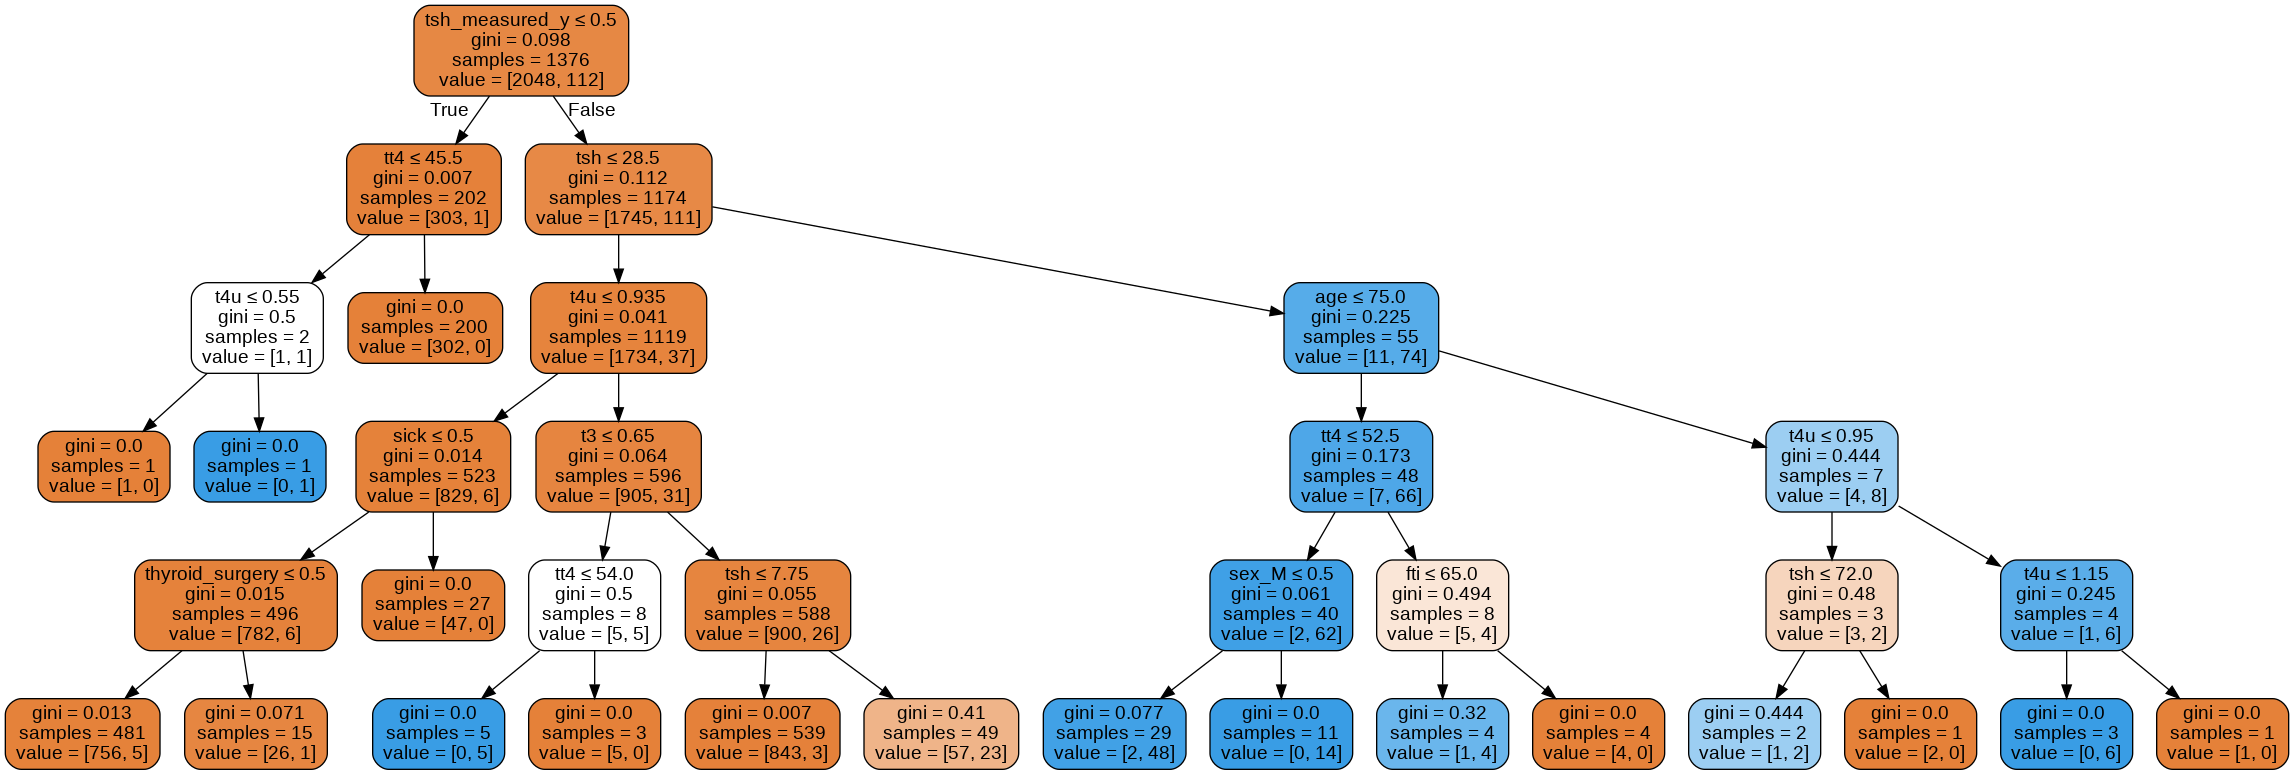

In [ ]:
# picking the 3rd tree from the forest
tree = rf.estimators_[3]

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Cross Validation to check for the stability of the model

In [ ]:
# Performing cross validation of ten folds
#
scores = cross_val_score(rf, X, y, scoring = 'f1', cv = 10)

# Calculating the mean of the cross validation scores
#
print(f'Mean of cross validation scores is {scores.mean()}')

# Calculating the variance of the cross validation scores from the mean
#
print(f'Standard deviation of the cross validation scores is {scores.std()}')

Mean of cross validation scores is 0.8425111925111924
Standard deviation of the cross validation scores is 0.06444041762615443


*The true f1 score of the model is approximately 83%, with a variance of 0.058.*

## AdaBoostClassifier

In [ ]:
# Selecting the independent variables and the target variable
#
X = df.drop('status', axis = 1)
y = np.where(df.status == 'hypothyroid', 1, 0)

# Encoding categorical variables
#
X = pd.get_dummies(X)

# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
#
ada = AdaBoostClassifier(random_state = 0)
ada.fit(X_train, y_train)

# Making predictions
#
y_pred = ada.predict(X_test)

# Measuring the accuracy of the model
#
acc_1 = accuracy_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)

print(f'The accuracy score is: {acc_1} and the f1 score is {f1_1}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

The accuracy score is: 0.9935205183585313 and the f1 score is 0.9210526315789475


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       887
           1       0.95      0.90      0.92        39

    accuracy                           0.99       926
   macro avg       0.97      0.95      0.96       926
weighted avg       0.99      0.99      0.99       926



array([[885,   2],
       [  4,  35]])

*AdaBoostClassifier f1 score is way much better than that of the RandomForestClassifier*

### Feature Importance

In [ ]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X.columns, 'importance': ada.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df

,importance
feature,
fti,0.22
age,0.16
tsh,0.16
t4u,0.12
t3,0.12
tt4,0.12
on_antithyroid_medication,0.04
query_hypothyroid,0.02
thyroid_surgery,0.02


### Visualising the most important features

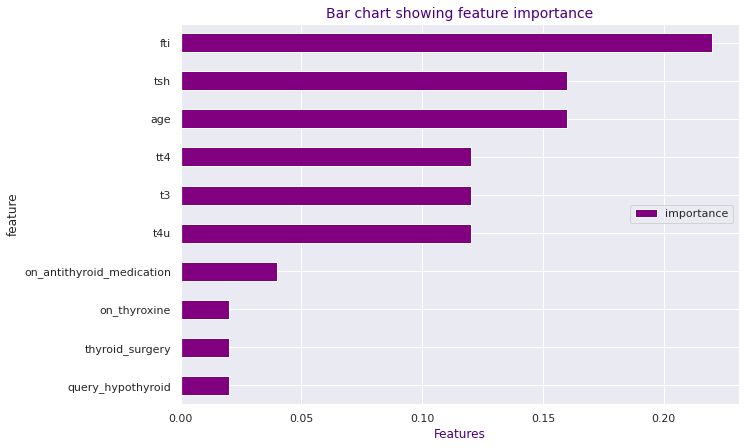

In [ ]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 7), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

*When compairing the most important features between the AdaBoostClassifier and RandomForestClassier; Ada uses fewer features and makes a better prediction. Ada only uses 10 features while RandomForest uses 12 features*

### Remodelling with the most important features only

In [ ]:
# Selecting only important features and the y variable
#
X = X[['fti', 'age', 'tsh', 't4u', 't3', 'tt4', 'on_antithyroid_medication', 'query_hypothyroid', 'thyroid_surgery', 'on_thyroxine']]

y = np.where(df.status == 'hypothyroid', 1, 0)

# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
#
ada = AdaBoostClassifier(random_state = 0)
ada.fit(X_train, y_train)

# Making predictions
#
y_pred = ada.predict(X_test)

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)} and the f1 score is {f1_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

The accuracy score is: 0.9935205183585313 and the f1 score is 0.9210526315789475


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       887
           1       0.95      0.90      0.92        39

    accuracy                           0.99       926
   macro avg       0.97      0.95      0.96       926
weighted avg       0.99      0.99      0.99       926



array([[885,   2],
       [  4,  35]])

### Hyperparameter Tuning

In [ ]:
# Previewing the parameters to tune
#
AdaBoostClassifier()

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
# Creating a dictionary of parameters to tune
#
params = {'n_estimators': [10, 20, 30, 50, 100],
         'learning_rate': [1, 2, 3, 4, 5]}

# Setting the number of folds to 10 and instantiating the model
# 
kfold = KFold(n_splits=10, shuffle=True)
model = AdaBoostClassifier()

search = GridSearchCV(model, param_grid=params, scoring = 'f1', cv = kfold)

# Fitting the grid search with the X and the y variables
#
search.fit(X, y)

# Checking for the best parameters
#
print(f'The best parameters are: {search.best_params_}')

The best parameters are: {'learning_rate': 1, 'n_estimators': 20}


In [ ]:
# Selecting only important features and the y variable
#
X = X[['fti', 'age', 'tsh', 't4u', 't3', 'tt4', 'on_antithyroid_medication', 'query_hypothyroid', 'thyroid_surgery', 'on_thyroxine']]

y = np.where(df.status == 'hypothyroid', 1, 0)

# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Instantiating the model
#
ada = AdaBoostClassifier(learning_rate=1, n_estimators=30, random_state = 0)
ada.fit(X_train, y_train)

# Making predictions
#
y_pred = ada.predict(X_test)

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)} and the f1 score is {f1_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

The accuracy score is: 0.9924406047516199 and the f1 score is 0.9090909090909091


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       887
           1       0.92      0.90      0.91        39

    accuracy                           0.99       926
   macro avg       0.96      0.95      0.95       926
weighted avg       0.99      0.99      0.99       926



array([[884,   3],
       [  4,  35]])

### Visualising the 3rd stump 

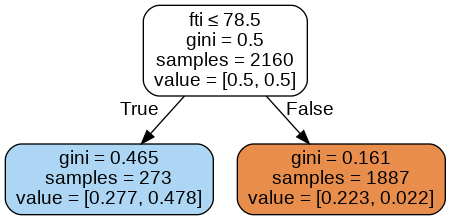

In [ ]:
dot_data = StringIO()
# pick a specific tree from the forest
tree = ada.estimators_[3]

export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Cross Validation to check for the stability of the model

In [ ]:
# Performing cross validation of ten folds
#
scores = cross_val_score(ada, X, y, scoring = 'f1', cv = 10)

# Calculating the mean of the cross validation scores
#
print(f'Mean of cross validation scores is {scores.mean()}')

# Calculating the variance of the cross validation scores from the mean
#
print(f'Standard deviation of the cross validation scores is {scores.std()}')

Mean of cross validation scores is 0.871661347592382
Standard deviation of the cross validation scores is 0.09766432601055766


*When comparing Ada and RandomForest, Ada has a general f1 score of 87% while RandomForest has a general f1 score of 83%. Therefore AdaBoostClassifier is a better predicter than RandomForestClassifier for this dataset*

## Support Vector Classifier

### Comparing svc kernels to find the one with a maximum f1 score - using only two features

In [ ]:
# Selecting the independent variables and the target variable
#
X = df[['fti', 'tsh']].values
y = np.where(df.status == 'hypothyroid', 1, 0)

# Instantiating and creating a list of models for iteration
#
poly = SVC(kernel='poly')
linear = SVC(kernel = 'linear')
rbf = SVC(kernel ='rbf')

# Creating a list of the models and model names
#
models = [poly, linear, rbf]
model_names = ['Polynomial', 'Linear', 'Rbf']
# Creating a function that trains a model and returns its accuracy together with the model
#
def predictor(model, X, y):
  # Splitting the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
  
  # Standardising the data
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)
  
  # Training the model and making predictions
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  # Measuring the accuracy of the model
  f1 = f1_score(y_test, y_pred)
  acc = accuracy_score(y_test, y_pred)
  
  # Returning the accuracy and the model
  return acc, f1, model

# Getting the accuracies of the models  using a for loop
#
for model, name in zip(models, model_names):
  print(f'The accuracy score of {name:<10} is: {predictor(model, X, y)[0]} and the f1 score is: {predictor(model, X, y)[1]}')

The accuracy score of Polynomial is: 0.9838012958963283 and the f1 score is: 0.7692307692307693
The accuracy score of Linear     is: 0.9859611231101512 and the f1 score is: 0.8169014084507042
The accuracy score of Rbf        is: 0.9848812095032398 and the f1 score is: 0.7941176470588235


*The best performing Support Vector Classifier kernel is linear. It has an f1 score of approximately of 81% which is more than that of polynomial and rbf*

### Hyperparameter tuning to find the optimal C and gamma values

In [ ]:
# Previewing parameters of the SVC model that can be tuned
#
SVC()

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Creating a dictionary of parameters to tune
#
params = {'C': np.arange(1, 102, 10),
         'gamma': np.linspace(2**-5, 2**5, 10)}

# Setting the number of folds to 10 and instantiating the model
# 
kfold = KFold(n_splits=3, shuffle=True)
model = SVC(kernel = 'linear')

search = RandomizedSearchCV(model, param_distributions=params, scoring = 'f1', cv = kfold, random_state = 0)

# Selecting the independent variables and the target variable
#
X = df[['fti', 'tsh']]
y = np.where(df.status == 'hypothyroid', 1, 0)

# Fitting the grid search with the X and the y variables
#
search.fit(X, y)

# Checking for the best parameters
#
print(f'The best parameters are: {search.best_params_}')

The best parameters are: {'gamma': 17.791666666666668, 'C': 81}


### Remodelling with optimal parameters

In [ ]:
# Selecting only important features and the y variable
#
X = df.drop('status', axis = 1)

y = np.where(df.status == 'hypothyroid', 1, 0)

# Encoding categorical variables
#
X = pd.get_dummies(X)

# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Standardising features
#
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Instantiating the model with optimal features
#
svc = SVC(C = 21, gamma = 0.03125, kernel='linear')
svc.fit(X_train, y_train)

# Making predictions
#
y_pred = svc.predict(X_test)

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)} and the f1 score is {f1_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

The accuracy score is: 0.9881209503239741 and the f1 score is 0.8493150684931507


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       887
           1       0.91      0.79      0.85        39

    accuracy                           0.99       926
   macro avg       0.95      0.90      0.92       926
weighted avg       0.99      0.99      0.99       926



array([[884,   3],
       [  8,  31]])

### Crossvalidation to check the stability of the model

In [ ]:
# Performing cross validation of ten folds
#
scores = cross_val_score(svc, X, y, scoring = 'f1', cv = 10)

# Calculating the mean of the cross validation scores
#
print(f'Mean of cross validation scores is {scores.mean()}')

# Calculating the variance of the cross validation scores from the mean
#
print(f'Standard deviation of the cross validation scores is {scores.std()}')

Mean of cross validation scores is 0.8133239546283024
Standard deviation of the cross validation scores is 0.07691071483570998


*Between the three models, Ada, RandomForest and SVC; the Ada performs best followed by RandomForest and svc respectively*

## Challenging the solution

*Using different models to check whether performance can be improved*

In [ ]:
# Importing different classification models
#
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Creating a list of classifier algorithms to compare with
#
models = [GradientBoostingClassifier(), DecisionTreeClassifier(), XGBClassifier(), KNeighborsClassifier(),\
          GaussianNB(), LogisticRegression()]

# Creating lists of the algorithms, to store the accuracy scores of each fold
#
GradientBoosting, DecisionTree, XGB, KNeighbors, GaussianNB, LogisticRegression = ([] for x in range(6))

# Creating a list containig the list of each algorithm. Created for easy iteration
#
model_list = [GradientBoosting, DecisionTree, XGB, KNeighbors, GaussianNB, LogisticRegression]

# Selecting the independent variables and the target variable
#
X = df.drop('status', axis = 1)
y = np.where(df.status == 'hypothyroid', 1, 0)

# Encoding categorical variables
#
X = pd.get_dummies(X)

# Creating a cross validation of 10 folds
#
kfold  = KFold(n_splits=10, shuffle = True, random_state = 0)

# Iterating through each model and appending the scores of each fold to the appriopriate list
#
for i, j in zip(models, model_list):
  j.extend(list(cross_val_score(i, X, y, scoring = 'f1', cv = kfold)))
  
# Creating a dataframe of all the scores from the iterations for each model
#
scores = pd.DataFrame({'GradientBoosting': GradientBoosting, 'DecisionTree': DecisionTree, 'XGB': XGB,\
              'KNeighbors': KNeighbors, 'GaussianNB': GaussianNB, 'LogisticRegression': LogisticRegression}, index = range(1, 11))

# Calculating the mean and standard deviation score of each algorithm
#
scores.loc['mean'] = scores.mean()
scores.loc['std'] = scores.std()

# Previewing the scores dataframe
#
scores

,GradientBoosting,DecisionTree,XGB,KNeighbors,GaussianNB,LogisticRegression
1,0.960000,0.846154,1.000000,0.956522,0.086275,0.909091
2,0.880000,0.888889,0.880000,0.782609,0.102362,0.782609
3,0.965517,1.000000,1.000000,0.888889,0.114286,0.846154
4,0.941176,0.909091,0.941176,0.875000,0.127820,0.838710
5,0.971429,0.914286,0.971429,0.875000,0.131783,0.812500
6,0.761905,0.727273,0.782609,0.818182,0.073529,0.736842
7,0.864865,0.833333,0.914286,0.709677,0.130612,0.838710
8,0.810811,0.777778,0.857143,0.777778,0.139344,0.666667
9,0.952381,0.909091,0.952381,0.909091,0.082305,0.947368
10,0.869565,0.909091,0.833333,0.818182,0.081301,0.761905


In [ ]:
# Finding the model with the highest accuracy
#
scores.loc['mean'].idxmax()

'XGB'

*An alternative model that can match or outperform the AdaBoostClassifier is the XGBClassifier. More data is needed to increase the predictive power of the model. As the data is highky imbalanced, The f1 score metric of success has been used*

## Conclusion

* *Out of all the models used to predict whether a person has hypothyroid, the AdaBoostClassifier performs well with an f1 score of approximately 86%*


*  *The best performing kernel in the SupportVectorClassifier is Linear with an accuracy score 98.5% of and an f1 score of 86.%*


